# Notebook comparing wavelet calculation methods

In [2]:
from collections import defaultdict

import dill
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = True
mpl.rcParams["font.size"] = 15
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
mpl.rcParams["axes.titlesize"] = "xx-large"  # medium, large, x-large, xx-large

mpl.style.use("seaborn-deep")

from itertools import groupby

In [3]:
# Wavelet calculation from motionmapperpy
def fastWavelet_morlet_convolution_parallel(modeno, x, f, omega0, dt, useGPU):
    if useGPU>=0:
        import cupy as np
        np.cuda.Device(useGPU).use()
    else:
        import numpy as np
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))

    if not N // 2:
        x = np.concatenate((x, [0]), axis=0)
        N = len(x)
        wasodd = True
    else:
        wasodd = False

    x = np.concatenate([np.zeros(int(N / 2)), x, np.zeros(int(N / 2))], axis=0)
    M = N
    N = len(x)
    scales = (omega0 + np.sqrt(2 + omega0 ** 2)) / (4 * np.pi * f)
    Omegavals = 2 * np.pi * np.arange(-N / 2, N / 2) / (N * dt)

    xHat = np.fft.fft(x)
    xHat = np.fft.fftshift(xHat)

    if wasodd:
        idx = np.arange((M / 2), (M / 2 + M - 2)).astype(int)
    else:
        idx = np.arange((M / 2), (M / 2 + M)).astype(int)

    for i in range(L):
        m = (np.pi ** (-0.25)) * np.exp(-0.5 * (-Omegavals * scales[i] - omega0) ** 2)
        q = np.fft.ifft(m * xHat) * np.sqrt(scales[i])

        q = q[idx]
        amp[i, :] = np.abs(q) * (np.pi ** -0.25) * np.exp(0.25 * (omega0 - np.sqrt(omega0 ** 2 + 2)) ** 2) / np.sqrt(
            2 * scales[i])
    # print('Mode %i done.'%(modeno))
    return amp

In [4]:
def fastWavelet_morlet_convolution_parallel_annotated(modeno, x, f, omega0, dt, useGPU):
    
    if useGPU >= 0:
        import cupy as np

        np.cuda.Device(useGPU).use()
    else:
        import numpy as np
    N = len(x)
    # 
    L = len(f)
    amp = np.zeros((L, N))

    if not N // 2:
        x = np.concatenate((x, [0]), axis=0)
        N = len(x)
        wasodd = True
    else:
        wasodd = False
    
    # Add borders
    x = np.concatenate([np.zeros(int(N / 2)), x, np.zeros(int(N / 2))], axis=0)
    M = N
    N = len(x)
    
    # s(f) => Scale is dependent on frequency
    # C3
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    Omegavals = 2 * np.pi * np.arange(-N / 2, N / 2) / (N * dt)

    # fft to frequency-space then center 0 frequency for ease of use
    xHat = np.fft.fft(x)
    xHat = np.fft.fftshift(xHat)

    # omega0 = t in normal notation...

    # Just get the center, not the added buffer
    if wasodd:
        idx = np.arange((M / 2), (M / 2 + M - 2)).astype(int)
    else:
        idx = np.arange((M / 2), (M / 2 + M)).astype(int)

    # Loop over number of frequencies
    for i in range(L):
        # C2 without imaginary component
        # Morlet wavelet
        m = (np.pi ** (-0.25)) * np.exp(-0.5 * ((-Omegavals * scales[i] - omega0) ** 2))

        # Inverse fft and scale
        q = np.fft.ifft(m * xHat) * np.sqrt(scales[i])
        # Take center -- equivalent to real length
        q = q[idx]
        
        abs_w = np.abs(q)
        
        # C5
        cs = ((np.pi**-0.25) / np.sqrt(2 * scales[i])) * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2)) ** 2)
        
        # I'm not sure why we aren't multiplying by 1/C(s(f)) here
        # C6
        amp[i, :] = (
            (1/cs)*abs_w
        )
    print('Mode %i done.'%(modeno))
    del xHat
    return amp


## Setting up signal and wavelet

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

N_SECONDS = 5
SAMPLING_FREQ = 100
OMEGA0 = 1
MIN_FREQ = 0.1
MAX_FREQ = 50
N_FREQUENCIES = 50

dt = 1.0 / SAMPLING_FREQ

# Period is 1/freq
minT = 1.0 / MAX_FREQ
maxT = 1.0 / MIN_FREQ

# Distribute frequencies dyadically
Ts = minT * (
    2
    ** (
        (np.arange(N_FREQUENCIES) * np.log(maxT / minT))
        / (np.log(2) * (N_FREQUENCIES - 1))
    )
)
freqs = (1.0 / Ts)[::-1]

# t = np.linspace(0,N_SECONDS,N_SECONDS*SAMPLING_FREQ)

In [6]:
import numpy as np

t = np.linspace(0, 5 * 2 * np.pi, N_SECONDS*SAMPLING_FREQ)
sine_wave_raw = np.sin(t) + 2*np.cos(t*2)
sine_wave_censored = sine_wave_raw.copy()
center = int(len(sine_wave_censored) / 2)
sine_wave_censored[(center - 50):(center + 50)] = np.nan
sine_wave_df = pd.DataFrame(sine_wave_censored)
sine_wave_df.interpolate(method='pchip', axis=0, inplace=True)
sine_wave_interp = sine_wave_df.values.flatten()

sine_wave_set_0 = sine_wave_raw.copy()
sine_wave_set_0[(center - 50):(center + 50)] = 0



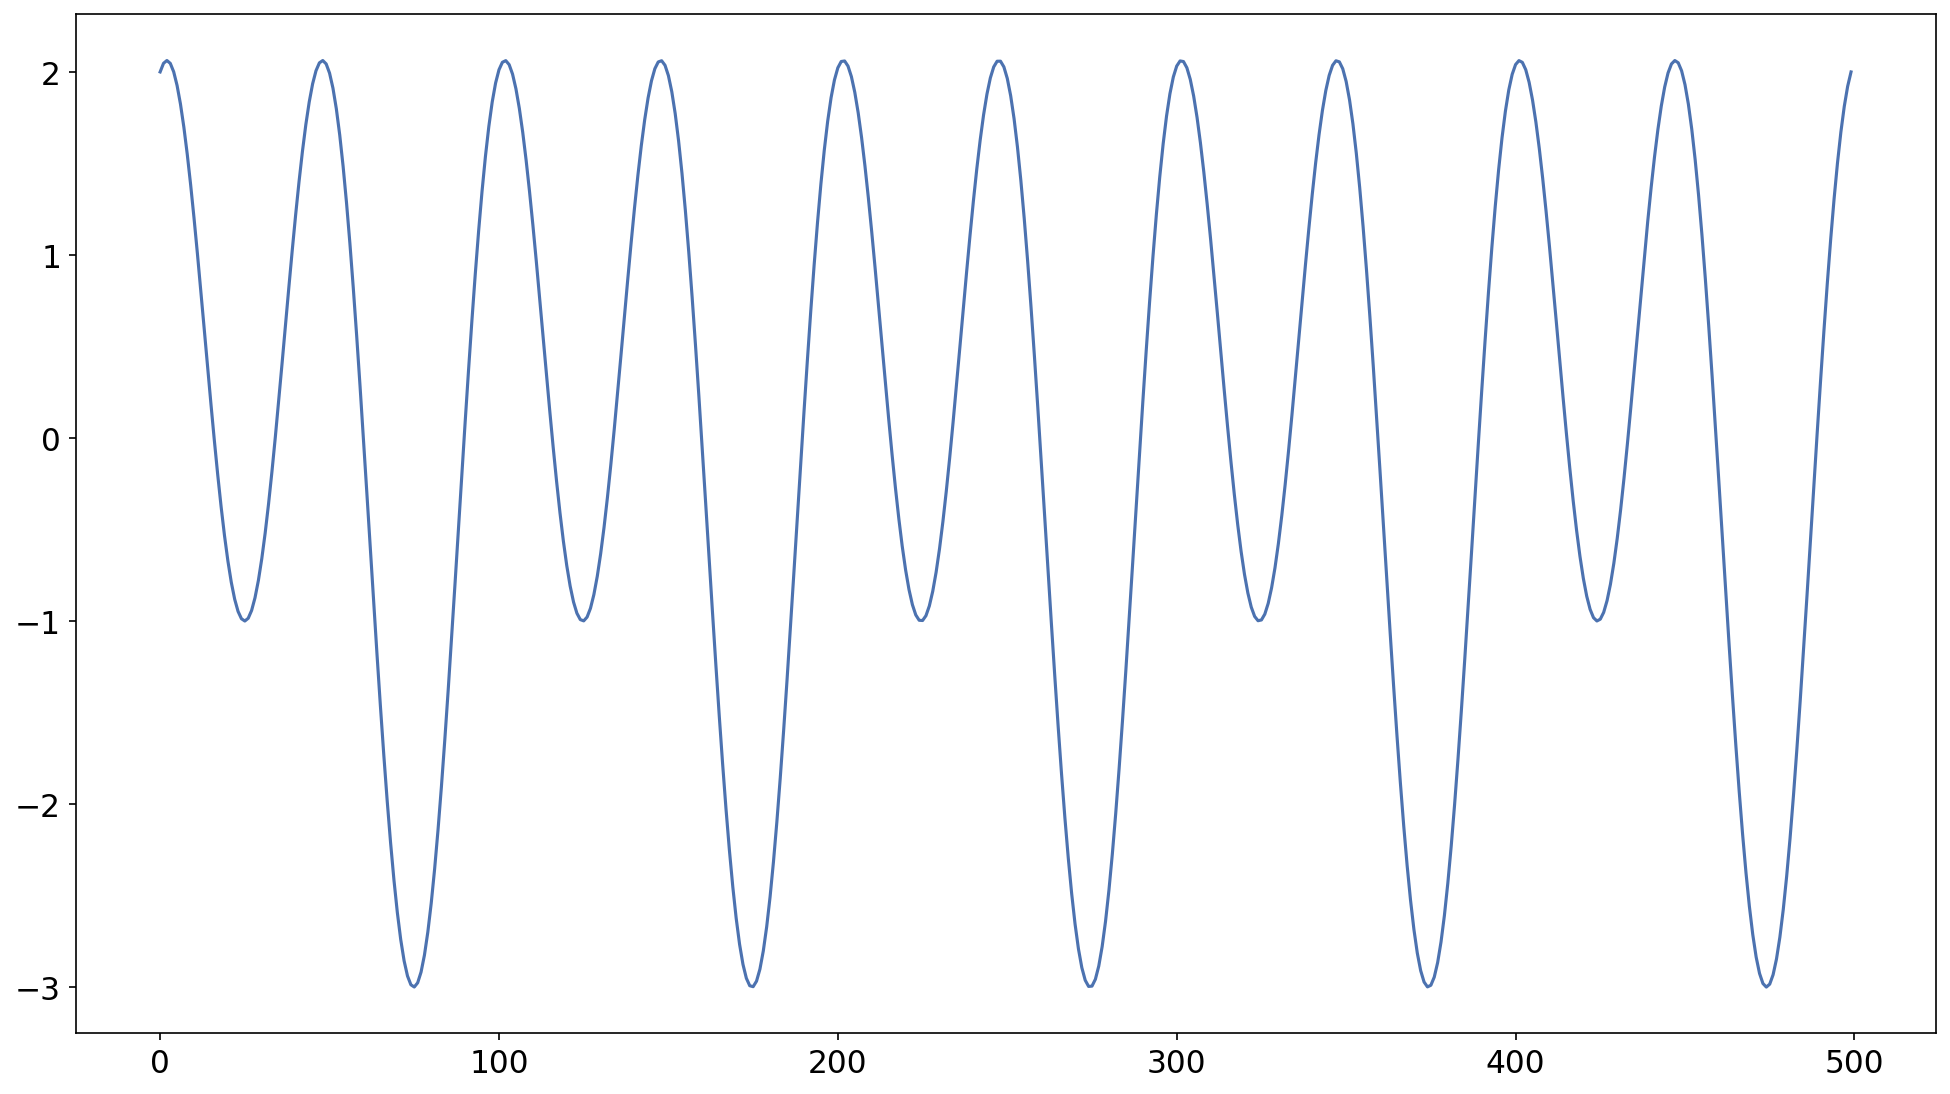

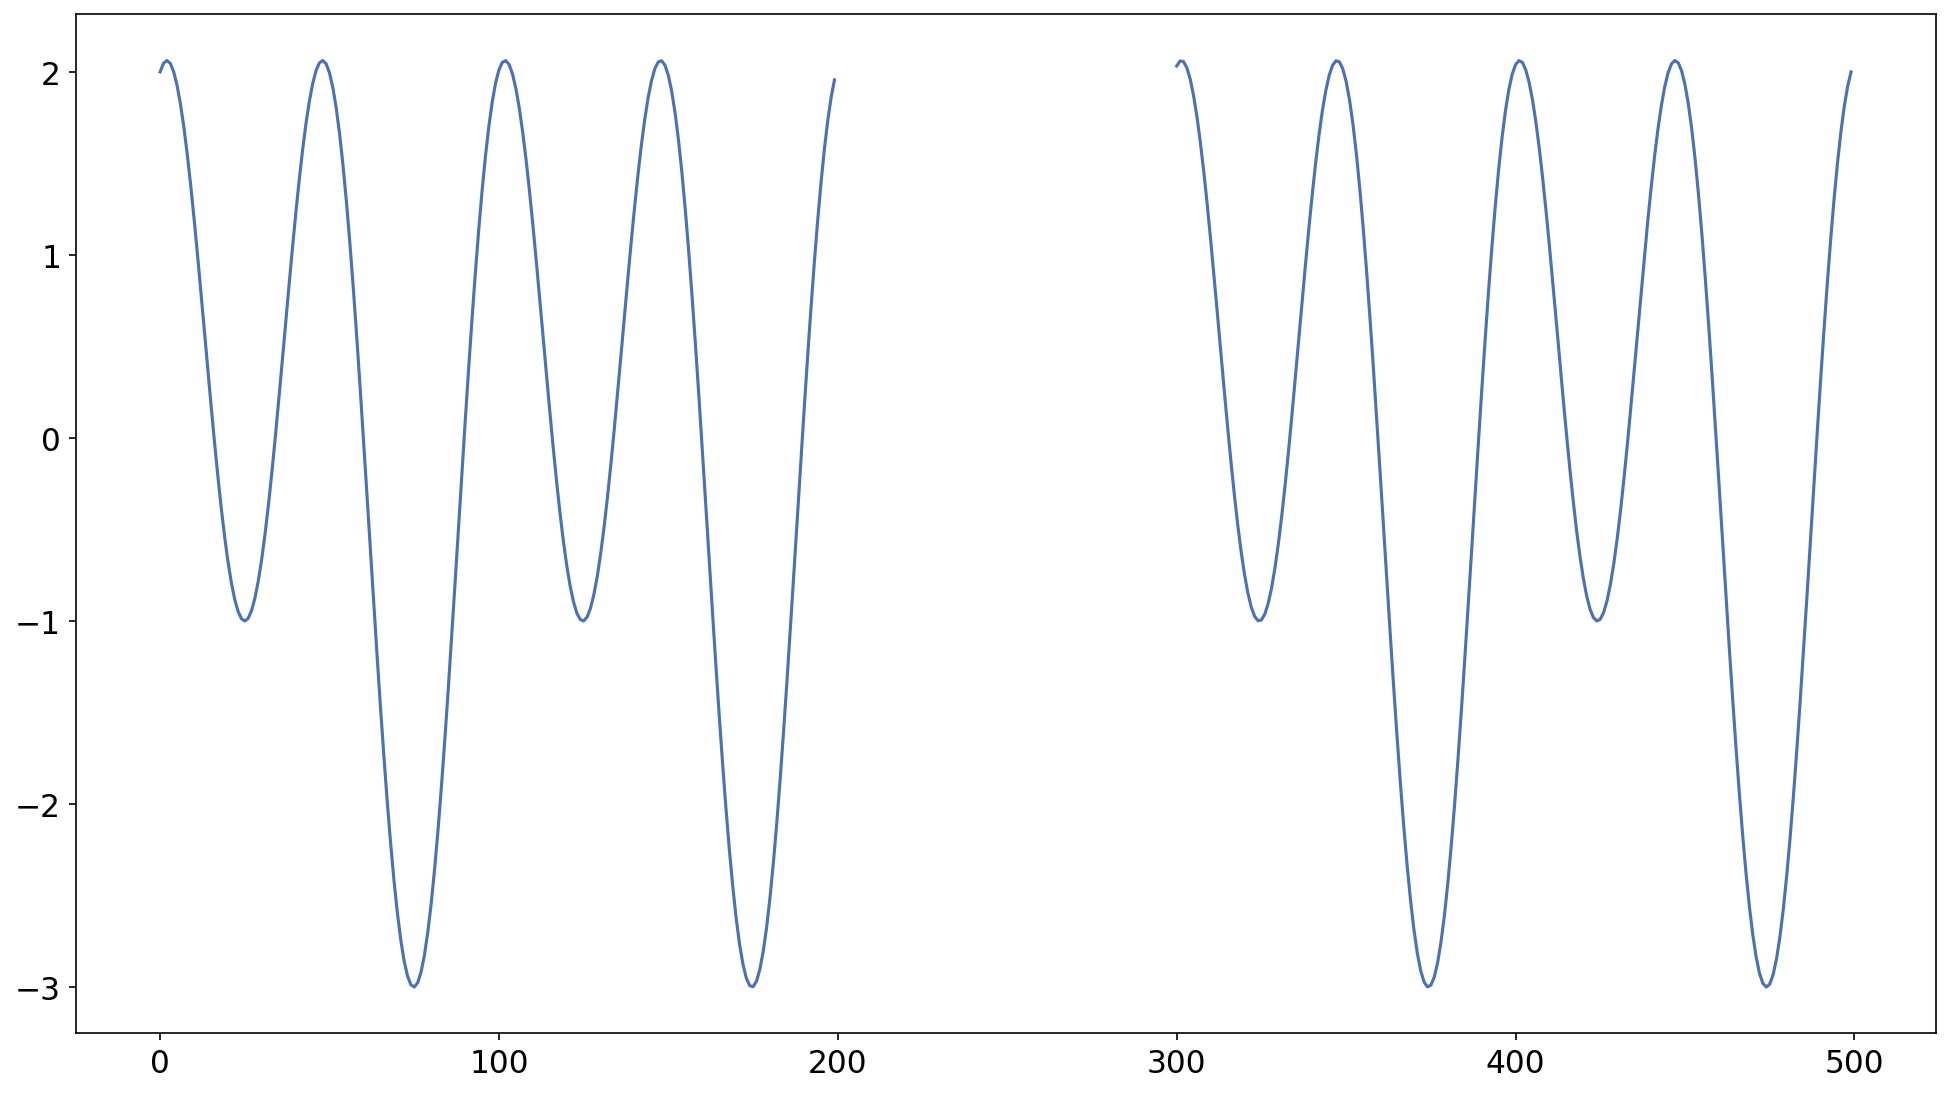

In [7]:
import pathlib
base_figure_path = pathlib.Path('wavelets_figures')
base_figure_path.mkdir(exist_ok=True, parents=True)

fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.plot(sine_wave_raw)
plt.savefig(base_figure_path / 'original_signal.png')

fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.plot(sine_wave_censored)
plt.savefig(base_figure_path / 'censored_signal.png')

Mode 0 done.
Mode 0 done.
Mode 0 done.
Mode 0 done.


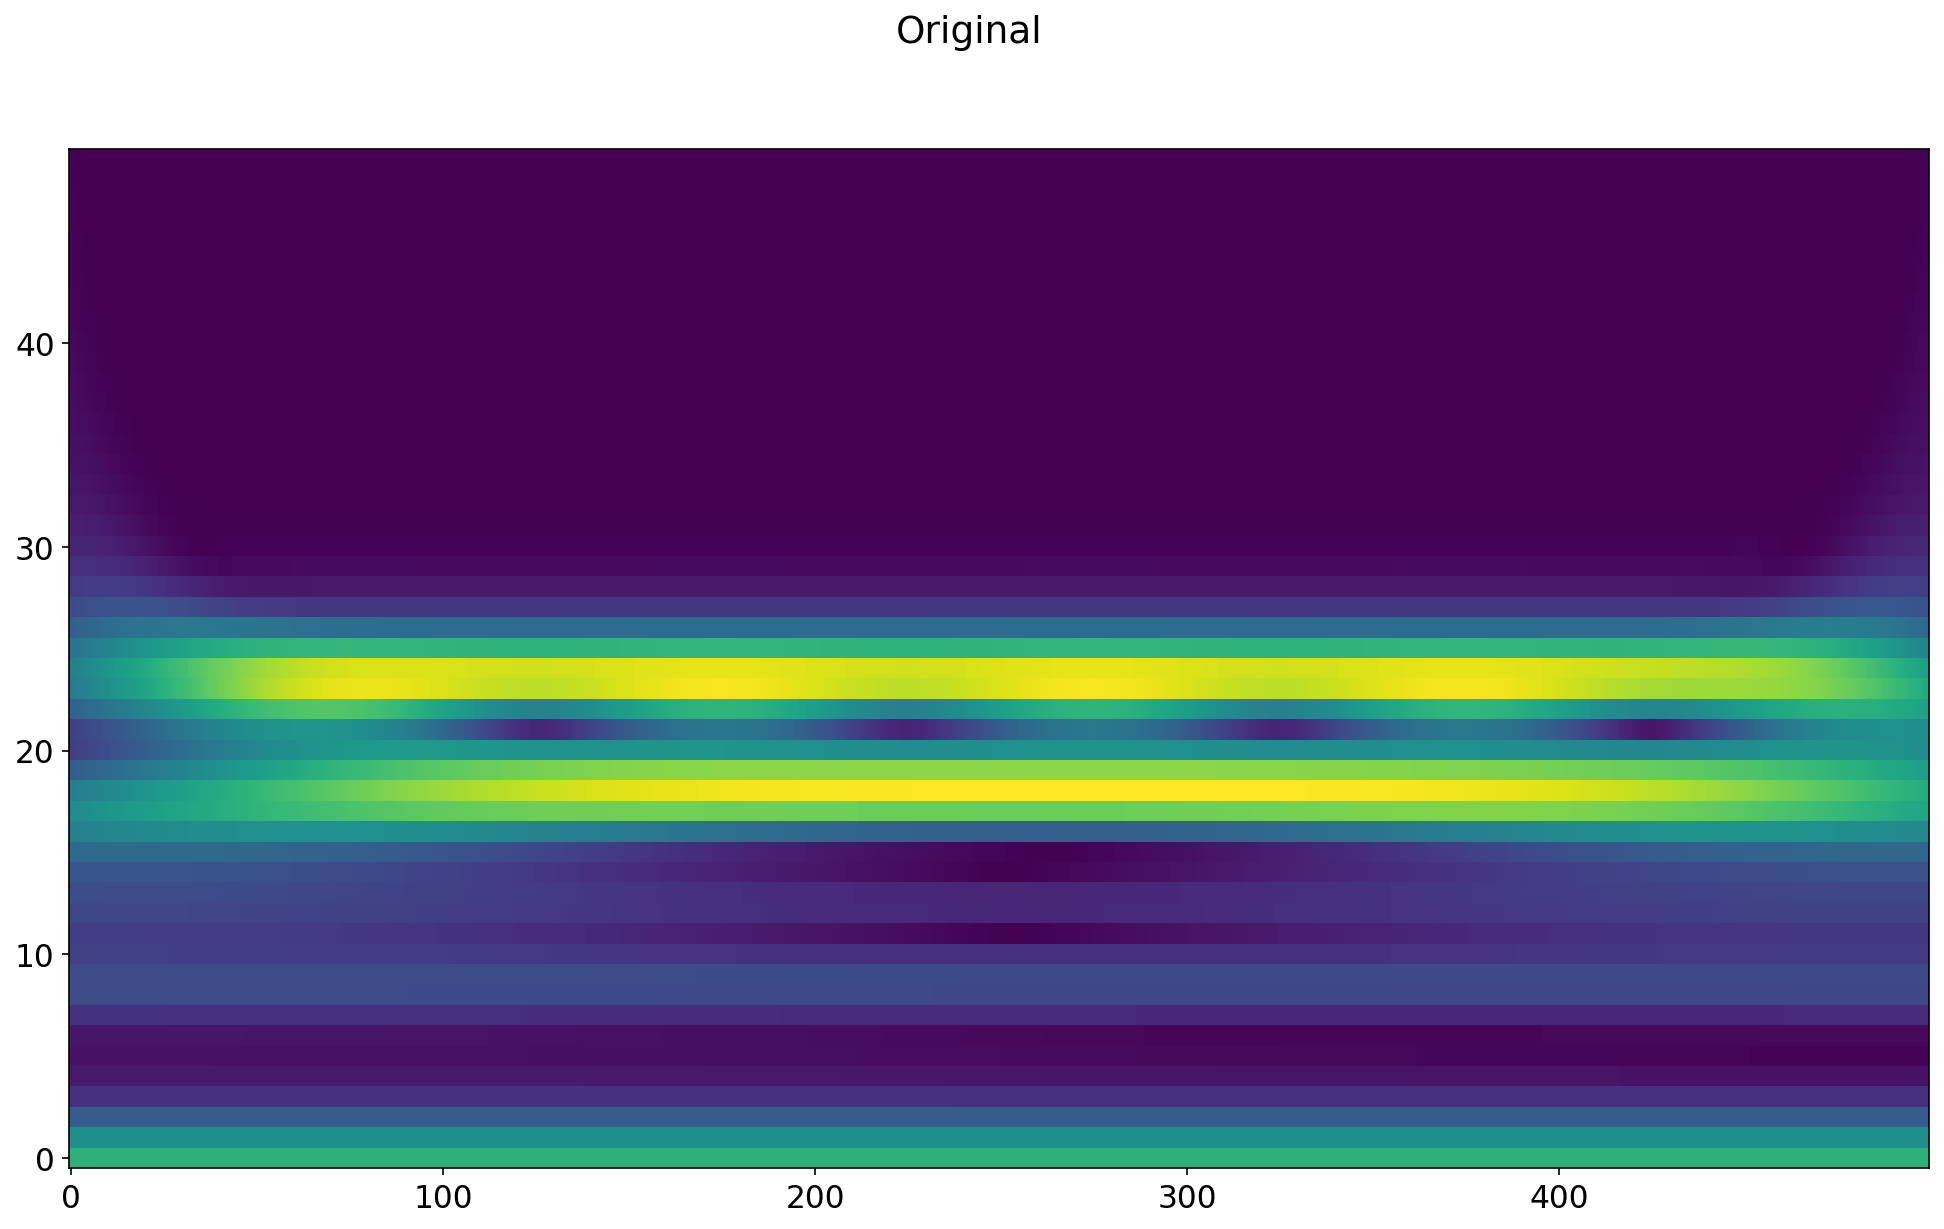

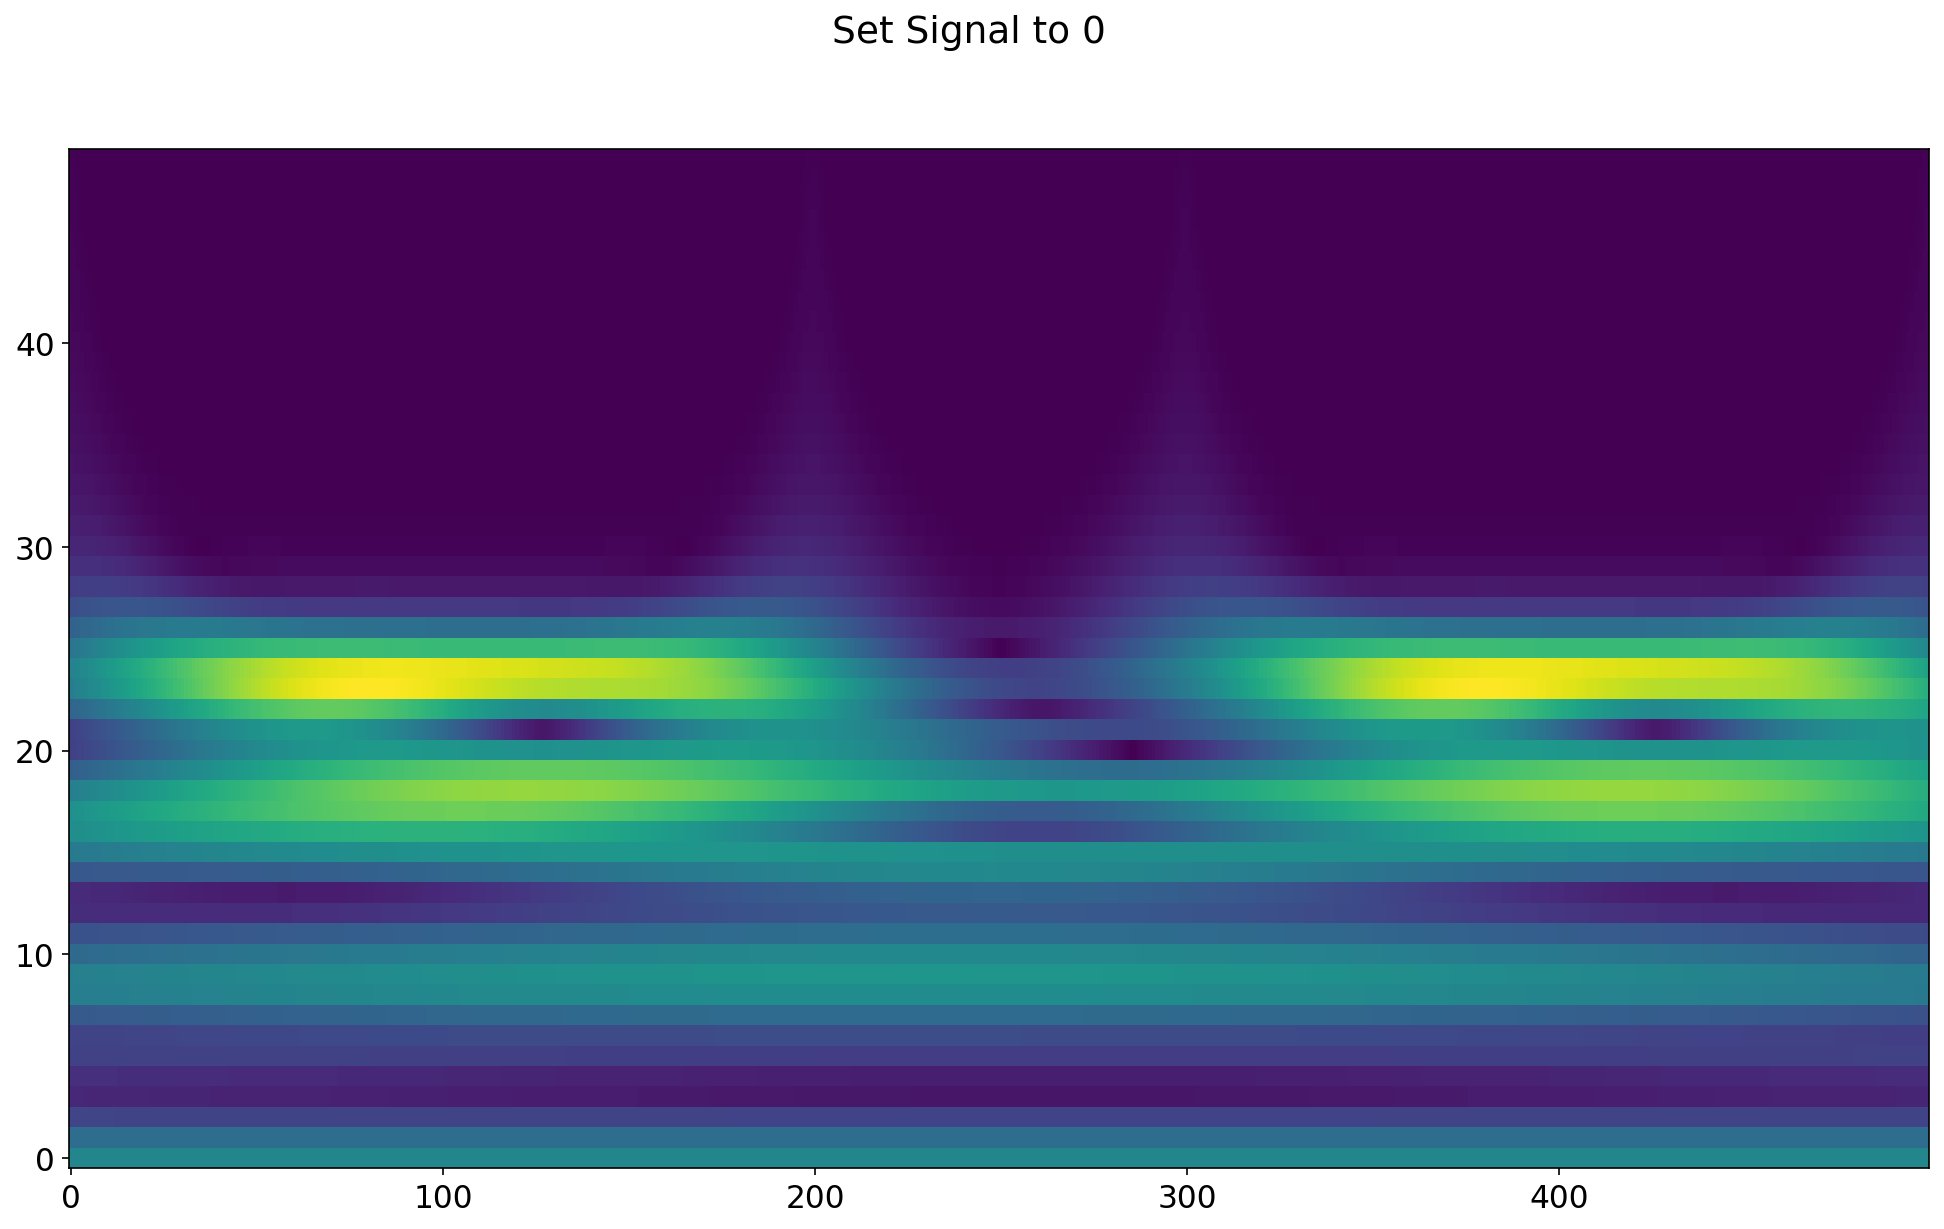

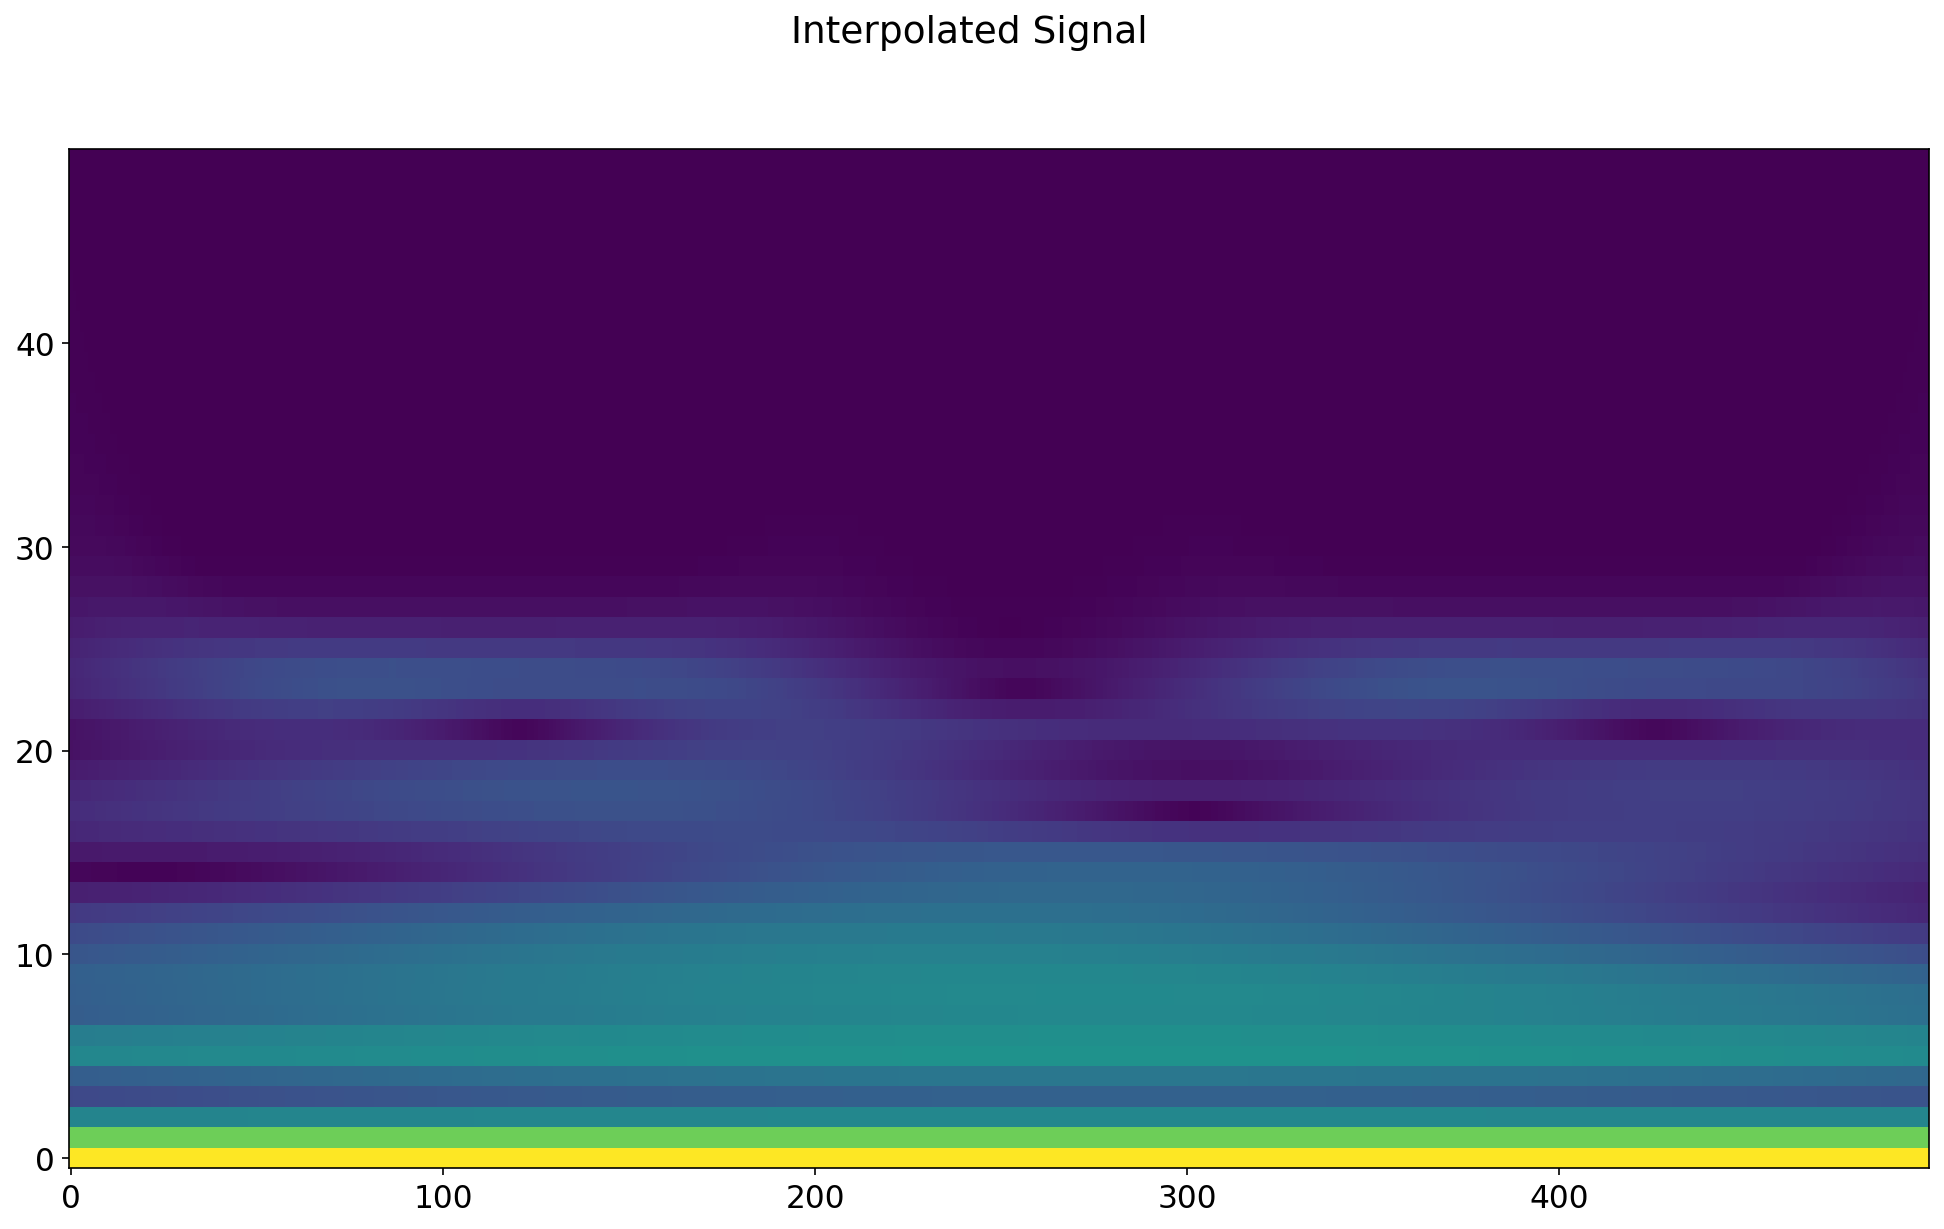

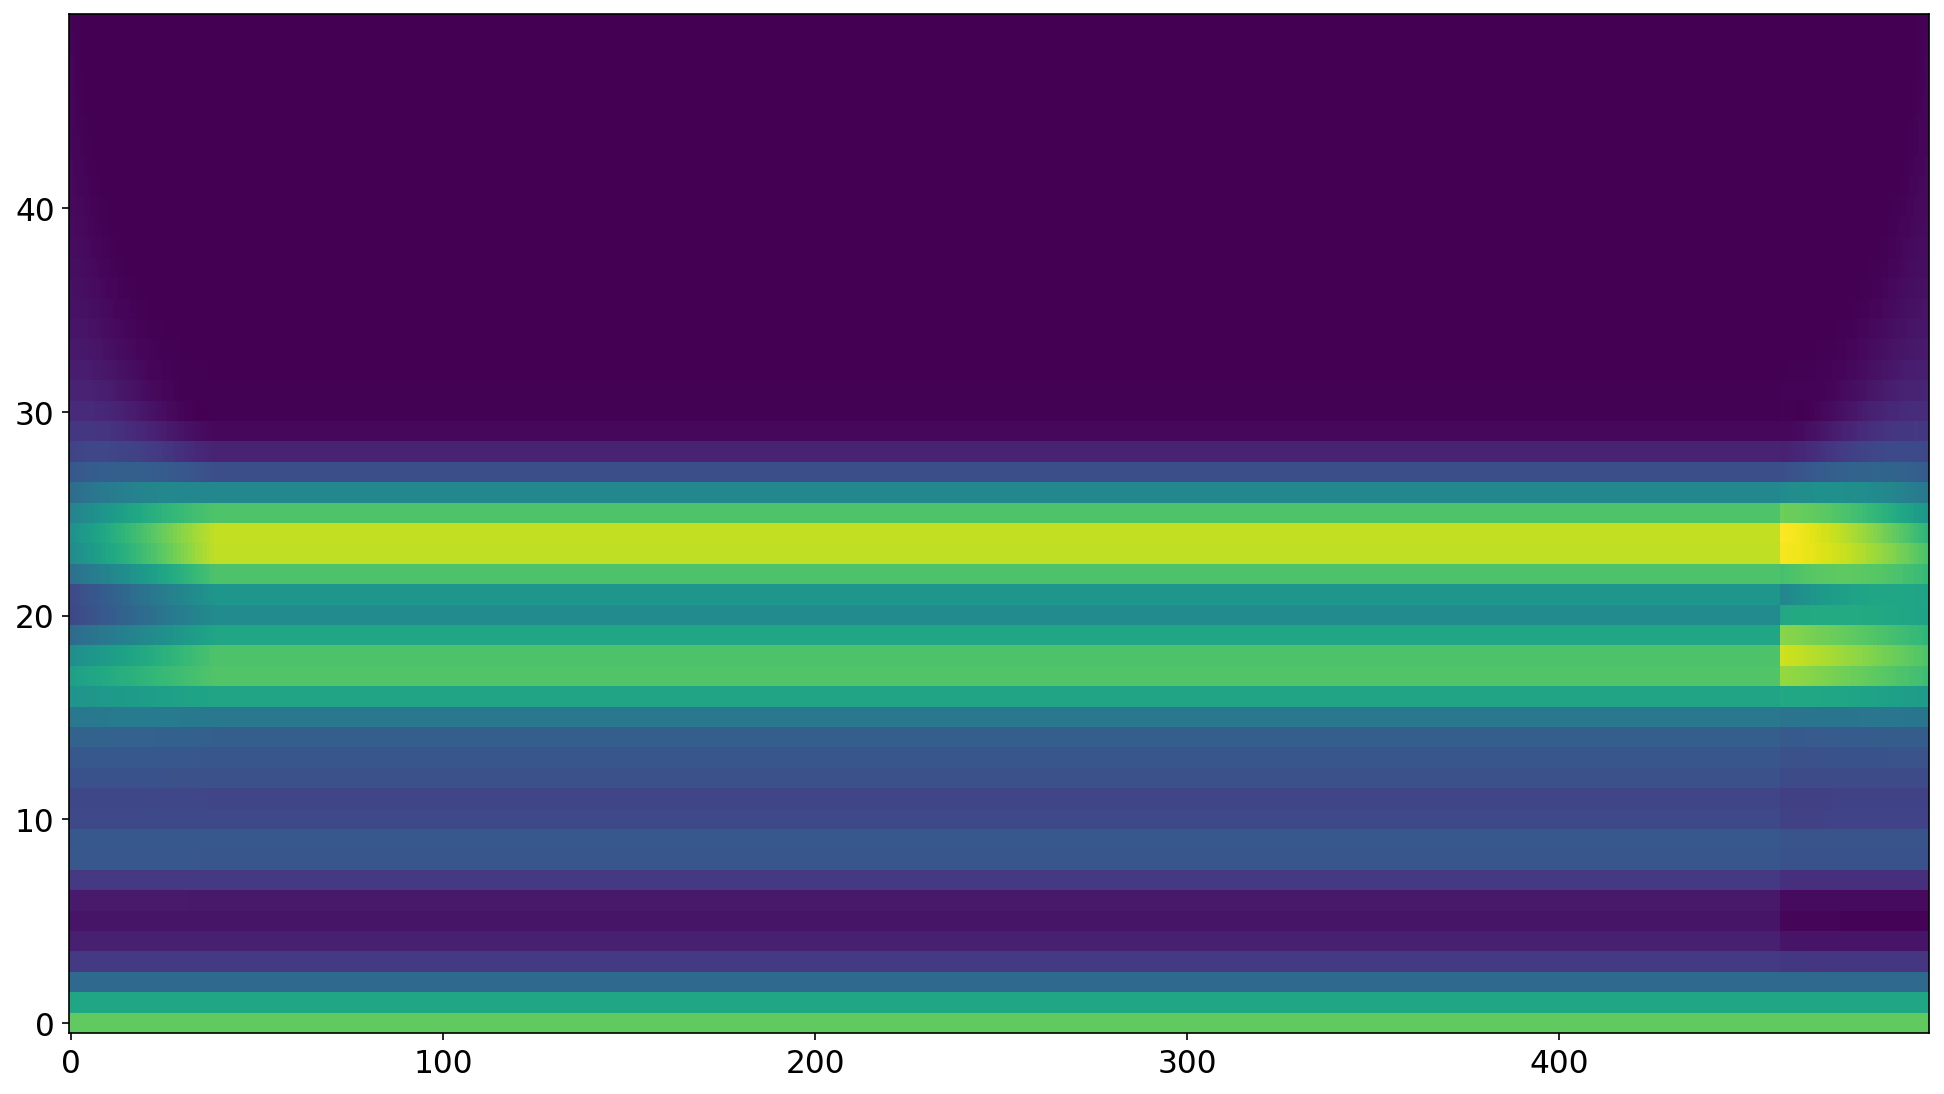

In [8]:


wavelets_orig = fastWavelet_morlet_convolution_parallel_annotated(0, sine_wave_raw, freqs, 5, 0.01, -1)
fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.imshow(wavelets_orig, aspect='auto')
ax.invert_yaxis()
plt.suptitle('Original')
plt.savefig(base_figure_path / 'original.png')

wavelets_signal_set_0 = fastWavelet_morlet_convolution_parallel_annotated(0, sine_wave_set_0, freqs, 5, 0.01, -1)
fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.imshow(wavelets_signal_set_0, aspect='auto')
ax.invert_yaxis()
plt.suptitle('Set Signal to 0')
plt.savefig(base_figure_path / 'set_signal_to_0.png')

wavelets_signal_interp = fastWavelet_morlet_convolution_parallel_annotated(0, sine_wave_interp, freqs, 5, 0.01, -1)
fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.imshow(wavelets_signal_interp, aspect='auto')
ax.invert_yaxis()
plt.suptitle('Interpolated Signal')
plt.savefig(base_figure_path / 'interpolated_signal.png')



wavelets_wolf = fastWavelet_morlet_convolution_parallel_annotated(0, sine_wave_raw, freqs, 5, 0.01, -1)
wavelets_wolf[:,40:-40] = np.nan
wavelets_interp = wavelets_wolf.copy()
wavelets_df = pd.DataFrame(wavelets_interp)
wavelets_df = wavelets_df.interpolate(method='ffill', axis=1)


fig, ax = plt.subplots(1,1, figsize=(16,9))
plt.imshow(wavelets_df.values, aspect='auto')
ax.invert_yaxis()
plt.savefig(base_figure_path / 'interpolated_wavelets.png')

In [11]:
t = np.linspace(0, 5 * 2 * np.pi, N_SECONDS*SAMPLING_FREQ)
raw_t = np.linspace(0, N_SECONDS, N_SECONDS*SAMPLING_FREQ)
sine_wave_raw = np.sin(t) + 2*np.cos(t*2)

In [30]:
import scipy.signal as signal

import numpy as np

import matplotlib.pyplot as plt

rng = np.random.default_rng()

A = 2.

w0 = 1.  # rad/sec

nin = 150

nout = 100000

x = raw_t

y = A * np.cos(w0*x)
y=sine_wave_raw

w = np.linspace(0.01, 10, nout)


import scipy.signal as signal

pgram = signal.lombscargle(x, y, w, normalize=True)

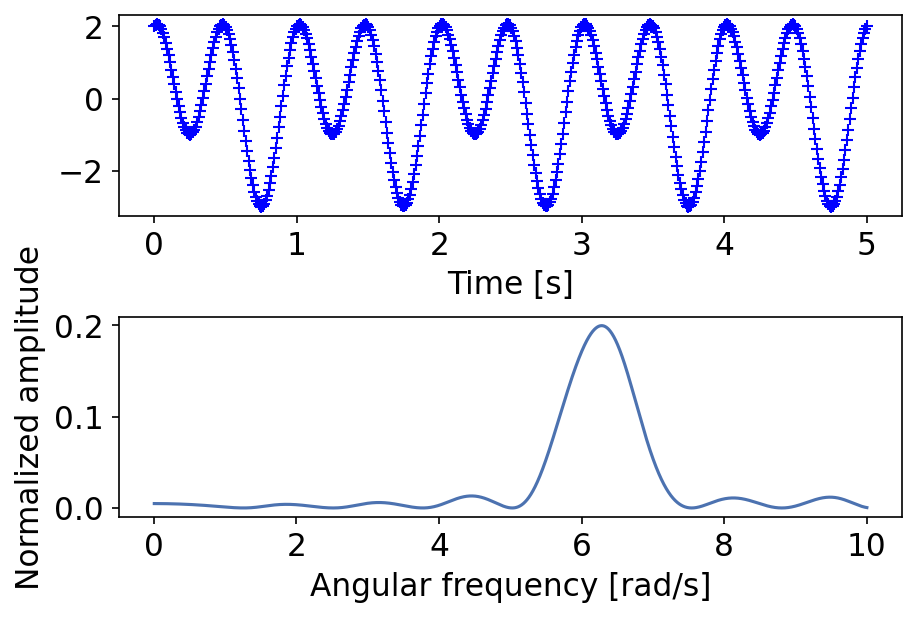

In [31]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)

ax_t.plot(x, y, 'b+')

ax_t.set_xlabel('Time [s]')
ax_w.plot(w, pgram)

ax_w.set_xlabel('Angular frequency [rad/s]')

ax_w.set_ylabel('Normalized amplitude')

plt.show()